In [1]:
import torch
from PIL import Image
import open_clip
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import random
mode_dataset=[("EVA02-E-14",'laion2b_s4b_b115k'),('ViT-L-14','datacomp_xl_s13b_b90k')]
model, _, preprocess = open_clip.create_model_and_transforms(mode_dataset[1][0], pretrained=mode_dataset[1][1])
model=model.to("cuda:1")
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer(mode_dataset[1][0])
import logging
%matplotlib inline
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)



/home/amin/miniconda3/envs/lsa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/amin/miniconda3/envs/lsa/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

In [2]:
def mine_attention(model,q_x, k_x, v_x, attn_mask):
  k_x = k_x if k_x is not None else q_x
  v_x = v_x if v_x is not None else q_x

  attn_mask = attn_mask.to(q_x.dtype) if attn_mask is not None else None
  return model.attn(
      q_x, k_x, v_x, need_weights=True, attn_mask=attn_mask
  )

def _expand_token(token, batch_size: int):
    return token.view(1, 1, -1).expand(batch_size, -1, -1)
def custom_forward(model,x):
  x = model.visual.conv1(x)  # shape = [*, width, grid, grid]
  x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
  x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

  # class embeddings and positional embeddings
  x = torch.cat([_expand_token(model.visual.class_embedding, x.shape[0]).to(x.dtype), x], dim=1)
  # shape = [*, grid ** 2 + 1, width]
  x = x + model.visual.positional_embedding.to(x.dtype)

  x = model.visual.patch_dropout(x)
  x = model.visual.ln_pre(x)
  transformer=model.visual.transformer
  for r in transformer.resblocks:
      q_x=x
      k_x = r.ln_1_kv(k_x) if hasattr(r, "ln_1_kv") and k_x is not None else None
      v_x = r.ln_1_kv(v_x) if hasattr(r, "ln_1_kv") and v_x is not None else None
      x_temp,att_weights=mine_attention(r,q_x=r.ln_1(q_x), k_x=k_x, v_x=v_x, attn_mask=None)
      x = q_x + r.ls_1(x_temp)
      x = x + r.ls_2(r.mlp(r.ln_2(x)))
  # for r in transformer.resblocks:
  #     q_x=x
  #     k_x = r.ln_1_kv(k_x) if hasattr(r, "ln_1_kv") and k_x is not None else None
  #     v_x = r.ln_1_kv(v_x) if hasattr(r, "ln_1_kv") and v_x is not None else None
  #     x = q_x + r.ls_1(r.attention(q_x=r.ln_1(q_x), k_x=k_x, v_x=v_x, attn_mask=None))
  #     x = x + r.ls_2(r.mlp(r.ln_2(x)))
  #     #x = r(x, attn_mask=None)
  x = model.visual.ln_post(x)
  pooled, tokens = model.visual._global_pool(x)
  pooled = pooled @ model.visual.proj
  return pooled,att_weights
def show_img2(img1, img2,name, alpha=0.8):
    
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(5, 5))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.savefig("attention_maps/"+name+"_merge")
    plt.close()
    
    fig = plt.figure(figsize=[10, 5], frameon=False)
    ax = fig.add_subplot(1, 2, 1)
    ax.axis("off")
    ax.imshow(img1)
    ax = fig.add_subplot(1, 2, 2)
    ax.axis("off")
    ax.imshow(img2)
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.savefig("attention_maps/"+name+"_seperated")
    plt.close('all')



In [3]:
roots=["CoCo-ThreeObject-BRBig","CoCo-ThreeObject-Middle-Big","CoCo-ThreeObject-ULBig"]
roots=["CoCo-ThreeObject-BRBig"]

image_list=[]
for root in roots:
    files=os.listdir(root)
    for file in files:
        image_list.append(root+"/"+file)
#image_list=random.sample(image_list,1000)



In [35]:
import json
with open("result1600.txt") as f:
    result_dict=json.load(f)
names=list(result_dict.keys())
valid_keys=[]
for key in names:
    if len(set(result_dict[key]["found_objects"].keys()))==3:
        valid_keys.append(key)

In [36]:
len(valid_keys)

4254

In [ ]:
for image_name in tqdm(image_list):
    name2key=image_name.split("/")[1].split(".")[0]
    if name2key in valid_keys:
        print("hello")


In [21]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f9f9a8cfb50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
!conda install imgaug -y

In [49]:
image.squeeze().permute(1,2,0).shape

torch.Size([224, 224, 3])

In [9]:
import lang_sam.utils as utils
np.asarray(Image.open(image_name).resize((224,224))).shape

(224, 224, 4)

In [81]:
img.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [94]:
torch.round(box).type(torch.int)*(224/512)

tensor([106.7500,  98.4375, 182.8750, 174.5625])

(1, 224, 224)

In [27]:
img.shape

(224, 224, 3)

In [41]:
img=np.asarray(Image.open(image_name).convert("RGB").resize((224,224))).copy()
img=attentions[0]
box=torch.round(boxes*(224/512)).type(torch.int)[0]
img[box[1]:box[3],box[0]:box[2]]=1
new=utils.draw_image(img[None].transpose(1,2,0),masks=[],boxes=boxes*(224/512),labels=["abs","asd","asd"])

In [38]:
attentions[0].shape

(224, 224)

In [47]:
image_name.split("/")[1].split("_").index("plates")

ValueError: 'plates' is not in list

In [56]:
image_name.split("/")[1].split(".")[0].split("_")

['remote', 'mouse', 'bed']

In [57]:
obj_dict={0:"UL",1:"M",2:"BR"}
obj_attn_dict={}
for key in obj_dict.keys():
    obj_attn_dict[obj_dict[key]]={"attn_sum":0,"count":0}
for image_name in tqdm(image_list):
    name2key=image_name.split("/")[1].split(".")[0]
    if name2key in valid_keys:
        coord_list=[]
        with torch.no_grad(), torch.cuda.amp.autocast():
            image = preprocess(Image.open(image_name)).unsqueeze(0)
            features,attention_weights = custom_forward(model,image.to("cuda:1"))
            cls_weight = attention_weights[0,0,1:][None].reshape(1,16,16).cpu()
            attentions = nn.functional.interpolate(cls_weight.unsqueeze(0), scale_factor=14, mode="nearest")[0].cpu().numpy()
            attention=attentions[0]
            name_list=image_name.split("/")[1].split(".")[0].split("_")
            for obj in result_dict[name2key]["found_objects"].keys():
                if obj in name_list:
                    box=torch.tensor(result_dict[name2key]["found_objects"][obj]["coords"])
                    box=torch.round(box*(224/512)).type(torch.int)
                    attn_sum=attention[box[1]:box[3],box[0]:box[2]].sum().item()
                    idx=name_list.index(obj)
                    obj_attn_dict[obj_dict[idx]]["attn_sum"]+=attn_sum
                    obj_attn_dict[obj_dict[idx]]["count"]+=1
                

        

100%|██████████| 8000/8000 [02:07<00:00, 62.95it/s]


In [53]:
result_dict[name2key]["found_objects"].keys()

dict_keys(['bed', 'mouse', 'remote'])

In [54]:
name_list

['remote', 'mouse', 'bed.png']

In [58]:
obj_attn_dict

{'UL': {'attn_sum': 43372.378115057945, 'count': 4190},
 'M': {'attn_sum': 44292.353141486645, 'count': 4193},
 'BR': {'attn_sum': 127253.0073466301, 'count': 4226}}

In [59]:
for key in obj_attn_dict.keys():
    attn_sum=obj_attn_dict[key]["attn_sum"]
    count=obj_attn_dict[key]["count"]
    avg=attn_sum/count
    obj_attn_dict[key]["avg"]=avg

In [60]:
obj_attn_dict

{'UL': {'attn_sum': 43372.378115057945,
  'count': 4190,
  'avg': 10.351402891421944},
 'M': {'attn_sum': 44292.353141486645,
  'count': 4193,
  'avg': 10.563404040421332},
 'BR': {'attn_sum': 127253.0073466301,
  'count': 4226,
  'avg': 30.111927909756293}}

In [42]:
boxes*(224/512)

tensor([[106.7286,  98.4566, 182.6849, 174.5015],
        [ 82.2340,  86.3997, 108.2167, 102.8590],
        [105.9697,  97.5226, 183.5395, 175.2576]])

  0%|          | 0/8000 [00:00<?, ?it/s]/tmp/ipykernel_25724/2716549087.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
  0%|          | 3/8000 [00:00<11:02, 12.07it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'attention_maps/BRBig_plate_laptop_pizza_merge.png'

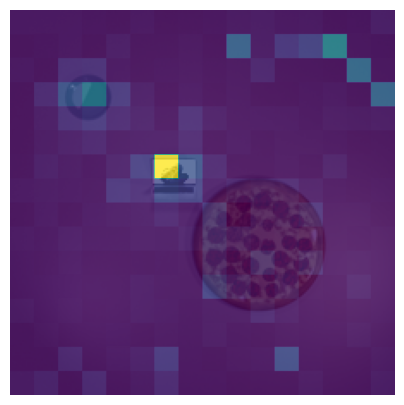

In [6]:
for image_name in tqdm(image_list):
    name2key=image_name.split("/")[1].split(".")[0]
    if name2key in valid_keys:
        coord_list=[]
        for obj in result_dict[name2key]["found_objects"].keys():
            coord=torch.tensor(result_dict[name2key]["found_objects"][obj]["coords"])
            coord_list.append(coord)
        boxes=torch.stack(coord_list)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image = preprocess(Image.open(image_name)).unsqueeze(0)
            features,attention_weights = custom_forward(model,image.to("cuda:1"))
            cls_weight = attention_weights[0,0,1:][None].reshape(1,16,16).cpu()
            attentions = nn.functional.interpolate(cls_weight.unsqueeze(0), scale_factor=14, mode="nearest")[0].cpu().numpy()
            img_resized = image[0].permute(1, 2, 0) * 0.5 + 0.5
            name=image_name.split("/")
            fname=name[0].split("-")[-1]
            sname=name[1].split(".")[0]
            full_name=fname+"_"+sname
            show_img2(img_resized, attentions[0],full_name,alpha=0.8)
        break    

In [5]:
!rm -rf attention_maps/*

In [1]:
!ls attention_maps | wc -l

2000


In [2]:
!zip -r attention_maps.zip attention_maps/*

  adding: attention_maps/Big_airplane_bear_spoon_merge.png (deflated 2%)
  adding: attention_maps/Big_airplane_bear_spoon_seperated.png (deflated 2%)
  adding: attention_maps/Big_airplane_scissors_pizza_merge.png (deflated 2%)
  adding: attention_maps/Big_airplane_scissors_pizza_seperated.png (deflated 2%)
  adding: attention_maps/Big_apple_bench_desk_merge.png (deflated 1%)
  adding: attention_maps/Big_apple_bench_desk_seperated.png (deflated 2%)
  adding: attention_maps/Big_apple_carrot_sandwich_merge.png (deflated 2%)
  adding: attention_maps/Big_apple_carrot_sandwich_seperated.png (deflated 3%)
  adding: attention_maps/Big_apple_desk_skateboard_merge.png (deflated 1%)
  adding: attention_maps/Big_apple_desk_skateboard_seperated.png (deflated 2%)
  adding: attention_maps/Big_apple_horse_vase_merge.png (deflated 2%)
  adding: attention_maps/Big_apple_horse_vase_seperated.png (deflated 2%)
  adding: attention_maps/Big_apple_refrigerator_remote_merge.png (deflated 2%)
  adding: attenti